In [1]:
import random
import py
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class Robot:
    def __init__(self, x, y, ID, orders):
        self.stop = False
        self.order_string = orders
        self.ID = ID #Number that labels the robot, so that we can refer to its figure.
        self.x, self.y = x, y
        self.log = np.zeros((10,10)); self.log[x,y] = 1
        self.obey(orders)
        
    def obey(self, orders):
        for l in orders:
            if l == 'r' and self.x < 9:
                self.x += 1
            elif l == 'l' and self.x > 0:
                self.x -= 1
            elif l == 'u' and self.y < 9:
                self.y += 1
            elif l == 'd' and self.y > 0:
                self.y -= 1
            self.log[self.x, self.y] += 1
        #print('current location: ({},{})'.format(self.x, self.y))
        self.log[self.x, self.y] = np.max(self.log) + 2 #Highlights last location.


In [3]:
def draw_trail(robot, goal):
        array = np.transpose(robot.log)
        array[goal] = robot.log[robot.x, robot.y] #Highlights goal.
        plt.figure(robot.ID)
        plt.imshow(array, origin='lower')

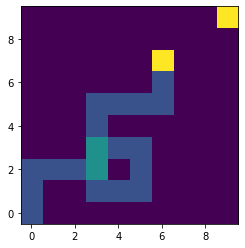

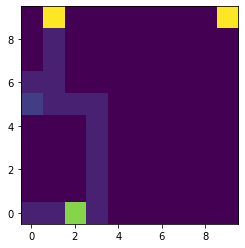

In [4]:
goal = (9, 9)

rob = Robot(0,0,0,'uurrrurrddlluuuurrruu')
draw_trail(rob, goal)

rob = Robot(0,0,1,'rrddddddddruuuuulllluruuuuuuu')
draw_trail(rob, goal)

We will use the genetic algorithm applied to order strings to arrive at a robot (with a certain order string which works as its DNA in the genetic analogy) which arrives at a specific goal.

## Generate initial population of robots.

Our initial population will be composed of $100$ robots.  
We will take all robots to start at $(0,0)$, so that what distinguishes them (their DNA if you will) is their order strings.  
These will be strings of length $18$ composed of the characters 'u', 'd', 'l' and 'r'.

Note: $18$ because no two positions are more than $18$ steps apart in our $10\times 10$ grid.

In [5]:
''.join(random.choices(['u','d','l','r'], k=18))

'ldlddllrdddldlduud'

In [6]:
pop_number = 10
max_steps = order_string_size = max_fitness = 18 #It will be explained later whi max_fitness has this value.
x = y = 0

random.seed(1) #To make sure we can discuss the results consistently.
#Let's create the robots.
def initialize_robots():
    global robots
    robots = []
    for ID in range(pop_number):
        orders_list = random.choices(['u','d','l','r'], k=order_string_size) #List of random orders.
        orders = ''.join(orders_list) #Make it a string.
        robots.append(Robot(x, y, ID, orders))
        #draw_trail(robots[ID], goal)

initialize_robots()

## Distance function, fitness and selection probabilities

In [7]:
def d1(X, Y):
    return abs(X[0]-Y[0]) + abs(X[1]-Y[1]) 

In [8]:
def fitness(robot):
    X = (robot.x, robot.y)
    return max_steps - d1(X, goal) #The closer to the goal, the higher the fitness.

In [9]:
def selection_prob(robot, robots):
    fitnesses = [fitness(robot) for robot in robots]
    prob = fitness(robot)/sum(fitnesses)
    return prob

In [10]:
def selection_probs(robots):
    probs = [selection_prob(robot, robots) for robot in robots]
    return probs

Total probability: 1.0 
 
 ==== Robots: === 

ID: 0, Fitness level: 6, Selection probability: 0.16666666666666666


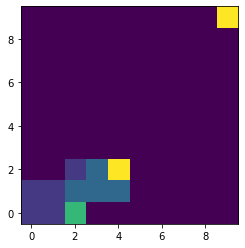

ID: 1, Fitness level: 4, Selection probability: 0.1111111111111111


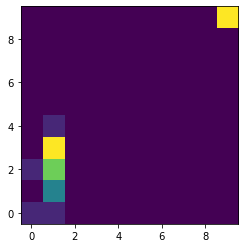

ID: 2, Fitness level: 2, Selection probability: 0.05555555555555555


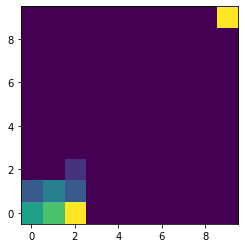

ID: 3, Fitness level: 1, Selection probability: 0.027777777777777776


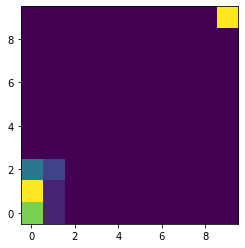

ID: 4, Fitness level: 0, Selection probability: 0.0


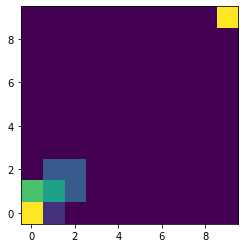

ID: 5, Fitness level: 1, Selection probability: 0.027777777777777776


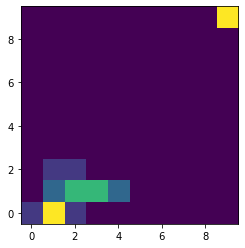

ID: 6, Fitness level: 9, Selection probability: 0.25


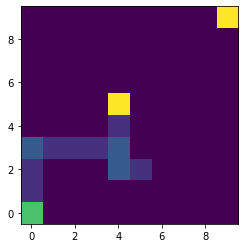

ID: 7, Fitness level: 1, Selection probability: 0.027777777777777776


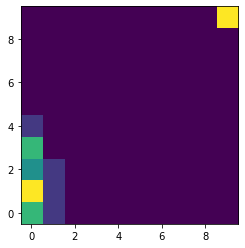

ID: 8, Fitness level: 8, Selection probability: 0.2222222222222222


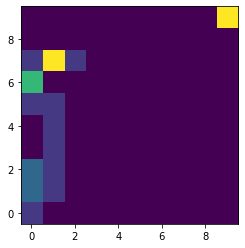

ID: 9, Fitness level: 4, Selection probability: 0.1111111111111111


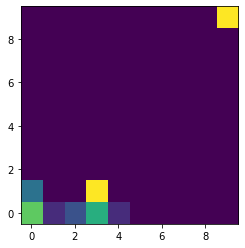

In [11]:
print( 'Total probability: {} \n \n ==== Robots: === \n'.format(sum(selection_probs(robots))) )
for ID in range(pop_number):
    robot = robots[ID]
    draw_trail(robot, goal)
    print('ID: {}, Fitness level: {}, Selection probability: {}'.format(ID, fitness(robot), selection_prob(robot, robots)))
    plt.show()

Notice that robots 6 and 8 have the highest selection probabilities.

## Selection

In [12]:
random.seed(1) #To make sure we can discuss the results consistently.
def selection(robots):
    '''
    robots is list with N entries containing one generation of robots (a population of robots).
    Returns a tuple:
        List of N robots, chosen according to their fitness: more fit --> more probable to be selected.
        List of IDs of the chosen robots.
    '''
    probs = selection_probs(robots) #Selection probabilities from fitness scores.
    indices = range(len(robots)) #Will choose indices (IDs) instead of robots directly, so that it's easy and efficient to know the chosen IDs.
    #Choice with replacement, to select robots on fitness:
    chosen_IDs = random.choices( population=indices, weights=probs, k=pop_number ) 
    chosen_robots = [robots[ID] for ID in chosen_IDs]
    return chosen_robots, chosen_IDs

print('Chosen IDs:', selection(robots)[1])

Chosen IDs: [0, 8, 8, 1, 6, 6, 7, 8, 0, 0]


Unsurprisingly, robots 6 and 8 are often chosen.

## Crossover

Each pair of selected robots will have two children, each of them getting part of their order string (analogous to DNA) from one parent, and part from the other.  
The amount selected from each parent is randomly selected.

In [13]:
random.seed(1)
def create_children(parent1, parent2, ID1, ID2):
    '''
    Each parent is an object of the class Robot.
    Returns a pair (tuple) of child robots (with identity numbers ID1, ID2) by crossing over the genetic information (the order strings) of the parents.
    '''
    cutoff = random.randint(0, order_string_size)
    #Create first child:
    contribution_1 = parent1.order_string[0:cutoff]
    contribution_2 = parent2.order_string[cutoff:order_string_size]
    orders = contribution_1 + contribution_2
    child1 = Robot(x, y, ID1, orders)
    #Create second child (reusing the cutoff):
    contribution_1 = parent2.order_string[0:cutoff]
    contribution_2 = parent1.order_string[cutoff:order_string_size]
    orders = contribution_1 + contribution_2
    child2 = Robot(x, y, ID2, orders)
    return child1, child2

#Example:
child_example1, child_example2 = create_children(robots[0], robots[1], 500, 1000)
print('Example: \n Parent 1 order string: {} \n Parent 2 order string: {} \n Child 1 order string: {} \n Child 2 order string: {}'.format(robots[0].order_string, robots[1].order_string, child_example1.order_string, child_example2.order_string))

Example: 
 Parent 1 order string: urrdddlruurdrudlur 
 Parent 2 order string: ruulrduduudduuuddu 
 Child 1 order string: urrdrduduudduuuddu 
 Child 2 order string: ruulddlruurdrudlur


## Mutation

We will randomly mutate one gene of each child.

In [14]:
random.seed(1)
def mutate(robot):
    '''
    '''
    #Original DNA:
    order_string = robot.order_string
    #Choose random gene to mutate:
    i = random.randint(0, len(order_string)-1)
    gene = order_string[i]
    #Mutate gene:
    gene = random.choice(['u', 'd', 'l', 'r']) #Notice the gene can actually remain unmutated.
    #Change DNA:
    order_list = list(order_string) #Lists are easier and more officient to handle when assigning values.
    order_list[i] = gene
    mutated_order_string = ''.join(order_list)
    #Create mutated robot, with same ID as the original:
    mutated_robot = Robot(x, y, ID, mutated_order_string)
    return mutated_robot

In [15]:
#Example:
print('Original: ', robots[0].order_string)
print('Mutated: ',mutate(robots[0]).order_string)

Original:  urrdddlruurdrudlur
Mutated:  urrdudlruurdrudlur


Notice it was the second 'd' that mutated to a 'u'.

## The loop

9
iterations: 0, best fitness: 8


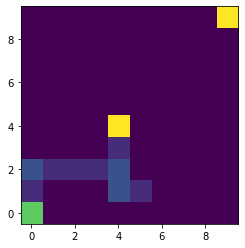

iterations: 5, best fitness: 7
iterations: 10, best fitness: 9
iterations: 15, best fitness: 8
iterations: 20, best fitness: 10


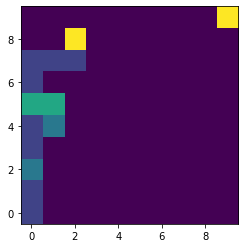

iterations: 25, best fitness: 11
iterations: 30, best fitness: 11
iterations: 35, best fitness: 14
iterations: 40, best fitness: 14


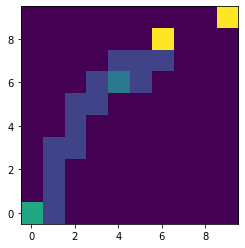

iterations: 45, best fitness: 16
iterations: 50, best fitness: 15
iterations: 55, best fitness: 14
iterations: 60, best fitness: 15


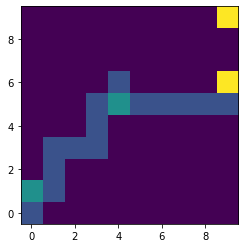

iterations: 65, best fitness: 15
iterations: 70, best fitness: 14
iterations: 75, best fitness: 14
iterations: 80, best fitness: 15


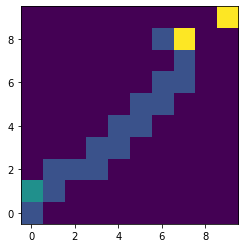

iterations: 85, best fitness: 13
iterations: 90, best fitness: 14
iterations: 95, best fitness: 12
iterations: 100, best fitness: 11


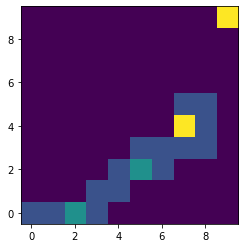

iterations: 105, best fitness: 16
iterations: 110, best fitness: 14
iterations: 115, best fitness: 14
iterations: 120, best fitness: 15


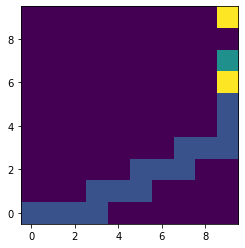

iterations: 125, best fitness: 14
iterations: 130, best fitness: 12
iterations: 135, best fitness: 16


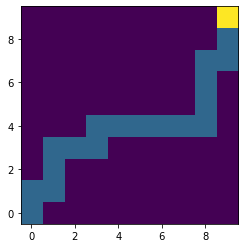

In [34]:
random.seed(1)
initialize_robots()

#I will store all the robot generations in a list so that it is easy to analyze the results and observe the evolution throughout the generations.
robot_gens = []

#Initialize best fitness.
fitness_levels = [fitness(robot) for robot in robots]
best_robot_fitness = max(fitness_levels)
print(best_robot_fitness)

fitness_log = [] #Will be used to plot the (best) fitness against iters.

iters = 0
max_iters = 200
while best_robot_fitness < max_fitness and iters <= max_iters: #That is, while no robot finishes at the goal position.
    robot_gens.append(robots) #Add current generation (population) to the dictionary of robot generations.
    #Selection of the fittest:
    selected_robots = selection(robots)[0]
    #Create children:
    for j in range(pop_number//2): #Will have pop_number/2 pairs of parents.
        parent1 = selected_robots[j]
        parent2 = selected_robots[pop_number//2 + j] #Easy way to select parents without (explicit) repetition.
        ID1, ID2 = j, pop_number//2 + j #Children will have same IDs as parents (in selected_robots, not robots - but it doesn't matter since len(selected_robots)=len(robots).
        child1, child2 = create_children(parent1, parent2, ID1, ID2)
        #Mutation
        child1, child2 = mutate(child1), mutate(child2)
        #Update robots list to included new (mutated) generation.
        robots[ID1], robots[ID2] = child1, child2
    #Update max_fitness:
    fitness_levels = [fitness(robot) for robot in robots]
    best_robot_fitness = max(fitness_levels)
    fitness_log.append(best_robot_fitness)
    #Print iterations and fitness info every 5 iterations:
    if iters%5 == 0: 
        print('iterations: {}, best fitness: {}'.format(iters, best_robot_fitness))
        #Visualize the best robot every 20 iterations. (Notice that this sits well inside the other if statement since 20%5==0)
        if iters%20 == 0:
            #Get the best robot of this generation:
            best_robot_index = fitness_levels.index(best_robot_fitness)
            best_robot = robots[best_robot_index]
            #Draw its trail:
            draw_trail(best_robot, goal)
            plt.show()
    #Update iters:
    iters += 1
#Get the best robot the final generation.
best_robot_index = fitness_levels.index(best_robot_fitness)
best_robot = robots[best_robot_index]
#Draw its trail:
draw_trail(best_robot, goal)
plt.show()

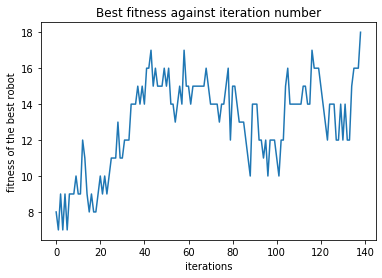

In [40]:
plt.figure()
plt.title('Best fitness against iteration number')
plt.xlabel('iterations')
plt.ylabel('fitness of the best robot')
plt.plot(range(iters), fitness_log)
plt.show()

## It worked!!

To do:
- Try mutation that affects more if fitness is low!! Less analogous to biology, but more efficient.
- Add possibility of mutating more than one gene.
- add obstacles.
- If the goal is in the middle, the robot can reach it sooner, and then go back, and have a high fitness! Maybe try to solve this to speed up convergence.
- Maybe select number of robots in initial population in accordance to the # of parameters and/or distance to the goal?
- do same in torus.
- explore 'variable space'.
- add option to kill all humans.

## References

- [Norvig]: Russell, Stuart J., and Peter Norvig. *Artificial intelligence: a modern approach*. Malaysia; Pearson Education Limited,, 2016.